## Benchmarking `pthread` Performance

I wrote C functions that perform useless operations on matrices.  Specifically, the functions accept a pointer to a 2D array and set the value of every element in the array to its array index.  The goal of this exercise is to demonstrate that a truly parallel multithreaded C routine can be called from Python.

In [29]:
# Standard system imports
import ctypes
import pathlib

# Related third party imports
import numpy as np

c_lib = ctypes.CDLL("../C/lib/libbenchmarking.so") # Location of C shared library

### Test Serial Routine

First, I wrote a simple function that sets the values in the array serially.  This is the function that will be timed as a baseline.  To ensure that the routine operates as expected, I generate a small 4x4 Numpy array of zeros and pass it to the C function `serial_routine`.

In [30]:
# Set data types of serial C function's arguments and return value
serial_routine = c_lib.serial_routine
serial_routine.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.POINTER(ctypes.c_double)]
serial_routine.restype = None  # C function returns void

# Generate a 4x4 matrix of zeros and run one repetition
mat_dim = 4
reps = 1
mat = np.zeros((mat_dim, mat_dim), dtype=np.double)
mat_ptr = mat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

# Print results
print("Before:")
print(mat)
serial_routine(reps, mat_dim, mat_ptr)
print("\nAfter:")
print(mat)

Before:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

After:
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]


### Test Parallel Routine

The parallel routine is similar to the serial routine, but it only operates over a range of rows of the matrix.  This allows multiple threads to operate on the matrix simultaneously by accessing different rows of the matrix.

When writing the parallel routine I found that `pthread_create()` will only accept a single argument to the function passed to it.  My parallel function has multiple arguments, and so I must create a struct to contain all of the arguments that I want to pass.  A pointer to the struct can then be passed to `pthread_create()` (although it must be cast as a pointer to void).

This seems simple enough, but one of my arguments is a pointer to a variable length array (VLA) of doubles.  C structs do not accept pointers to VLAs, and I spent many hours searching for a workaround.  I finally found [an obscure Stackoverflow post](https://stackoverflow.com/questions/63220508/how-can-i-define-a-pointer-to-variable-length-array-vla-in-a-struct-or-equiva) that had a working solution.  I'm still not entirely sure that I understand *why* it works, but it does work.

First, I verify that the struct will be accepted by `parallel_routine()` by initializing the struct in a C routine called `init_struct()` which then calls `parallel_routine()` with a pointer to the struct as its argument:

In [3]:
# Set data types of C routine to create a struct and pass it to parallel_routine()
init_struct = c_lib.init_struct
init_struct.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.c_int, ctypes.c_int, ctypes.POINTER(ctypes.c_double)]
init_struct.restype = None  # C function returns void

# Generate a 4x4 matrix of zeros and run one repetition, only modify second row of matrix
mat_dim = 4
reps = 1
start_row = 1
end_row = 2

mat = np.zeros((mat_dim, mat_dim), dtype=np.double)
mat_ptr = mat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

# Print results
print("Before:")
print(mat)
init_struct(reps, mat_dim, start_row, end_row, mat_ptr)
print("\nAfter:")
print(mat)

Before:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

After:
[[0. 0. 0. 0.]
 [4. 5. 6. 7.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Next, I experiment with creating the struct in Python code.  `ctypes` allows a struct to be defined as a class that inherits from `ctypes.Structure`.  The struct can be created in a C routine as shown above, but both methods might be useful and so I created a Python struct class **MatData** to mimic the **mat_data** struct defined in the C code.  I was concerned as to whether the Python version of the struct would work if I passed a pointer to double as the "mat" argument, but it appears to work without issue:

In [4]:
class MatData(ctypes.Structure):
    """Creates a mat_data struct."""

    _fields_ = [('reps', ctypes.c_int),
                ('dims', ctypes.c_int),
                ('mat', ctypes.POINTER(ctypes.c_double)),
                ('row_start', ctypes.c_int),
                ('row_end', ctypes.c_int)]
    

# Generate a 4x4 matrix of zeros and run one repetition, only modify third row of matrix
mat_dim = 4
reps = 1
start_row = 2
end_row = 3
    
mat = np.zeros((mat_dim, mat_dim), dtype=np.double)
mat_ptr = mat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

# Instantiate struct
mat_data = MatData()
mat_data.reps = reps
mat_data.dims = mat_dim
mat_data.mat = mat_ptr
mat_data.row_start = start_row # Modify only third row of matrix
mat_data.row_end = end_row

# Set data type of parallel routine to accept a pointer
parallel_routine = c_lib.parallel_routine
parallel_routine.argtypes = [ctypes.POINTER(MatData)]
parallel_routine.restype = None  # C function returns void

print("Before:")
print(mat)
parallel_routine(mat_data)
print("\nAfter:")
print(mat)

Before:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

After:
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 8.  9. 10. 11.]
 [ 0.  0.  0.  0.]]


### Benchmarking: Serial vs. Parallel Implementations

Finally, I wrote a multithreading routine that accepts the number of repetitions, the matrix dimension, them matrix pointer, and the number of desired threads.  Each thread will be supplied the `parallel_routine()` function and a `mat_data` struct that specifies which rows of the matrix that the thread should operate on.

Before benchmarking we'll test the routine with a small matrix:

In [6]:
# Set data types of multithreading routine arguments
multithreading_routine = c_lib.multithreading_routine
multithreading_routine.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.c_int, ctypes.POINTER(ctypes.c_double)]
multithreading_routine.restype = None  # C function returns void

# Generate a 4x4 matrix of zeros and run one repetition using 4 threads
mat_dim = 4
reps = 1
n_threads = 4

mat = np.zeros((mat_dim, mat_dim), dtype=np.double)
mat_ptr = mat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

print("Before:")
print(mat)
multithreading_routine(reps, mat_dim, n_threads, mat_ptr)
print("\nAfter:")
print(mat)

Before:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

After:
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]


The routine appears to work, and so now the serial implementation will be compared with the parallel implementation using 1, 2, 3, and 4 threads.  The matrix dimensions are 1000x1000, and the routines repeat 10,000 times.  The repeated calculations are useless, but the point is to occupy enough computation time to justify the overhead of creating threads.

In [17]:
run_times = []
mat_dim = 1000
reps = 10000

mat = np.zeros((mat_dim, mat_dim), dtype=np.double)
mat_ptr = mat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

run_time = %timeit -o serial_routine(reps, mat_dim, mat_ptr)
run_times.append(run_time)

3.55 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
for n_threads in range(1, 5):
    run_time = %timeit -o multithreading_routine(reps, mat_dim, n_threads, mat_ptr)
    run_times.append(run_time)

3.69 s ± 43.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.4 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.61 s ± 80.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.27 s ± 42.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


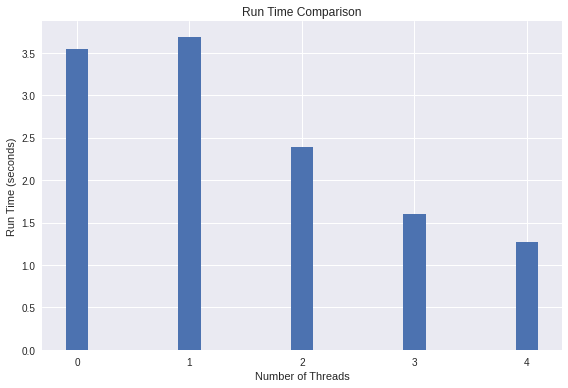

In [28]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn')

# Build the plot
bar_width = 0.2
x_spacing = np.arange(5)
fig, ax = plt.subplots()
ax.bar(x_spacing, [x.average for x in run_times], bar_width)

# Configure plot
ax.set_xlabel('Number of Threads')
ax.set_xticks(x_spacing)
ax.set_xticklabels(x_spacing)
ax.set_ylabel('Run Time (seconds)')
ax.set_title('Run Time Comparison')
plt.tight_layout()
plt.show()

### Discussion

The multithreading routine run with a single thread is slightly slower than the serial routine (0 threads), as expected.  Creating a single thread adds some overhead but otherwise provides no computational speed-up.  As more threads are added the run time does decrease.  This demonstrates that truly parallel multithreading can be accomplished in Python by calling C functions that utilize the `pthread` multithreading library.